## Data exploration and preprocessing

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp

In [3]:
# Create a SparkSession
spark = SparkSession.builder \
    .appName("Online Education Analysis") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

In [4]:
# Read data using Spark
info_content_df = spark.read.csv('Info_Content.csv', header=True, inferSchema=True)
info_user_data_df = spark.read.csv('Info_UserData.csv', header=True, inferSchema=True)
log_problem_df = spark.read.csv('Log_Problem.csv', header=True, inferSchema=True)

In [5]:
# Convert timestamp_TW to timestamp
df = log_problem_df.withColumn('timestamp_TW', to_timestamp(col('timestamp_TW')))
df = log_problem_df.filter(col('is_correct') == True)

In [6]:
# Count the number of attempts per user
user_attempts = df.groupBy('uuid').count()

In [7]:
# Show the result
user_attempts.show(10)

+--------------------+-----+
|                uuid|count|
+--------------------+-----+
|vWdGxGQwcZXltWscM...|   69|
|baP3hAJAHXLyeJUdT...|  363|
|yh/W1JQSK4yORzLPR...| 1902|
|XzjV7d232DDbc3fwZ...| 1381|
|hbSQBt8vw0oSsCG9B...|  316|
|mSxpLrWH1dwKumKuP...|   82|
|JM5kCGle6IYhSySSs...|  106|
|vuz3txDSqUvNHCcU/...|  175|
|e+ritEYXMn9OE97kj...|  610|
|PGLXaKLKtb5ac/sf1...|  154|
+--------------------+-----+
only showing top 10 rows



## Student success and engagement metrics calculation

In [8]:
from pyspark.sql.functions import countDistinct, avg, max

In [9]:
# Calculate the course completion rate for each student
course_completion = df.groupBy('uuid', 'ucid').agg(
    (countDistinct(col('is_correct')) / countDistinct(col('upid'))).alias('completion_rate')
)
course_completion.show(10)

+--------------------+--------------------+-------------------+
|                uuid|                ucid|    completion_rate|
+--------------------+--------------------+-------------------+
|hnN8ehncFhcp7vcSX...|hcs3eyiRWQEO5Wybd...|              0.125|
|Mv8h21Ednz5ngS319...|mf5PUtZaZKgrMrWPX...|0.08333333333333333|
|fzDlAauDlI/1U7dKR...|ItQToCzXe/WAeMATD...|                0.2|
|VJOgtCVRGattipuzD...|qkyb1eQM8HrW/1r3s...|0.14285714285714285|
|CCp0xqN4DKOzQ2Xig...|lvobiTtwUsd1ylmrc...|                0.2|
|hMjvKNhkM8gkMV5/t...|EH35TxVqqCRWfd7C+...| 0.3333333333333333|
|mUPGVUmpiAGmmjdl/...|JcrFXI7wzq/14kZRP...|              0.125|
|At8+kUYe3IFAxYhDY...|Fc5XlXIANxkaDJS1p...|0.14285714285714285|
|/MnvTFPg3Rac1pmKG...|fS8PvECka4NC8sJQe...|0.09090909090909091|
|IIQVw7IzrxIHk4+ky...|OmVUm+97EqL1PSeEy...|0.14285714285714285|
+--------------------+--------------------+-------------------+
only showing top 10 rows



In [10]:
# Add a new column 'score' to the DataFrame
df = log_problem_df.withColumn('score', (col('is_correct').cast('int'))) # True -> 1, False -> 0

# Calculate the average scores for each student in each course
average_scores = df.groupBy('uuid', 'ucid').agg(
    avg('score').alias('average_score')
)
average_scores.show(10)

+--------------------+--------------------+-------------------+
|                uuid|                ucid|      average_score|
+--------------------+--------------------+-------------------+
|COYqVYiAqRB6/4zTz...|hv7kHCAIdj7thZUml...|                1.0|
|EtOIPHJmsbHB7mf0C...|vj2oAek5lK+ewqbR0...|               0.25|
|VKX/20OsBPw5gPDmm...|hv7kHCAIdj7thZUml...|                1.0|
|rATIeTseZkaxavTrE...|AOPJ6VAg/KKkFJJKS...| 0.3333333333333333|
|LYmJmgmp1X7Evy2eu...|s6iUzyQUzDGLXdahm...|                0.0|
|HV/DYOcE2RKqxx/QL...|jyf7N5ZnreskNIwFO...|0.14814814814814814|
|/WekV6/KCXNSsq61t...|uL6KHETQYCoqBED2z...| 0.7142857142857143|
|j9tgaN1N7VGzQQpPl...|AqtrGa+Qvhqa4wB01...|                0.8|
|/YgMxeZH/uooHipXK...|44N1RXOiWg4Zy6x/G...|             0.6875|
|+at6EoOHfgPQ+RMVK...|hXLFyKcgM/LJH6GBA...|0.47368421052631576|
+--------------------+--------------------+-------------------+
only showing top 10 rows



In [11]:
# Analyze first login date for each student
info_user_data_df = info_user_data_df.withColumn('first_login_date_TW', to_timestamp(col('first_login_date_TW'), 'yyyy/MM/dd'))
first_login_analysis = info_user_data_df.groupBy('user_city').agg(
    max('first_login_date_TW').alias('latest_first_login')
)
first_login_analysis.show(10)

+---------+-------------------+
|user_city| latest_first_login|
+---------+-------------------+
|       ty|2019-07-31 00:00:00|
|      phc|2019-07-16 00:00:00|
|      hlc|2019-07-28 00:00:00|
|       kh|2019-07-31 00:00:00|
|       tp|2019-07-31 00:00:00|
|     ntpc|2019-07-31 00:00:00|
|       km|2019-07-08 00:00:00|
|       kl|2019-07-30 00:00:00|
|       hc|2019-07-29 00:00:00|
|       tn|2019-07-31 00:00:00|
+---------+-------------------+
only showing top 10 rows



In [12]:
# Display the number of student interactions
interactions = df.groupBy('uuid').agg(
    countDistinct('used_hint_cnt').alias('hints_used')
)
interactions.show(10)

+--------------------+----------+
|                uuid|hints_used|
+--------------------+----------+
|cWU7hCsq0l5ejSccO...|         6|
|mHO3uvrmUOGScJcRk...|         2|
|57q4vne+2/c28E2/M...|         6|
|DaRYq58VqJZlzBRz4...|         7|
|QC4qSfFQz8IuQlH9D...|         8|
|S5rc53aOBfe7UAxW0...|         6|
|Oil8KMxjWM5EFwf6t...|         7|
|9+td5WIVHe/vM/Rwu...|         3|
|3mGxM6+b0OUHJe2Bj...|         7|
|/DkrSLeU8t77Yx9C9...|         2|
+--------------------+----------+
only showing top 10 rows



## In-depth analysis and visualization

In [13]:
from pyspark.sql.functions import min, sum
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
# Load student exercise performance data
student_performance = log_problem_df.join(info_user_data_df, 'uuid').join(info_content_df, 'ucid')

# Make sure the 'score' column is added
student_performance = student_performance.withColumn('score', (col('is_correct').cast('int')))

# Make sure 'user_grade' column is available
student_performance = student_performance.withColumn('user_grade', col('user_grade'))

Performance by Grade

In [15]:
# Analyze performance by student grade
performance_by_grade = student_performance.groupBy('user_grade').agg(
    avg(col('score')).alias('average_score'),
    max(col('score')).alias('max_score'),
    min(col('score')).alias('min_score')
).orderBy('user_grade')  # Sort by grade

performance_by_grade.show()

+----------+------------------+---------+---------+
|user_grade|     average_score|max_score|min_score|
+----------+------------------+---------+---------+
|         1|0.7794948202199258|        1|        0|
|         2|0.7485471272936751|        1|        0|
|         3|0.7497257938039108|        1|        0|
|         4|0.7371591570254749|        1|        0|
|         5|0.7136067128402784|        1|        0|
|         6|0.6859273166003635|        1|        0|
|         7|0.6842689338608399|        1|        0|
|         8|0.6276601398703926|        1|        0|
|         9| 0.624073324184092|        1|        0|
|        10|   0.6246006603307|        1|        0|
|        11|0.6355376490187506|        1|        0|
|        12|0.6735707041050553|        1|        0|
+----------+------------------+---------+---------+



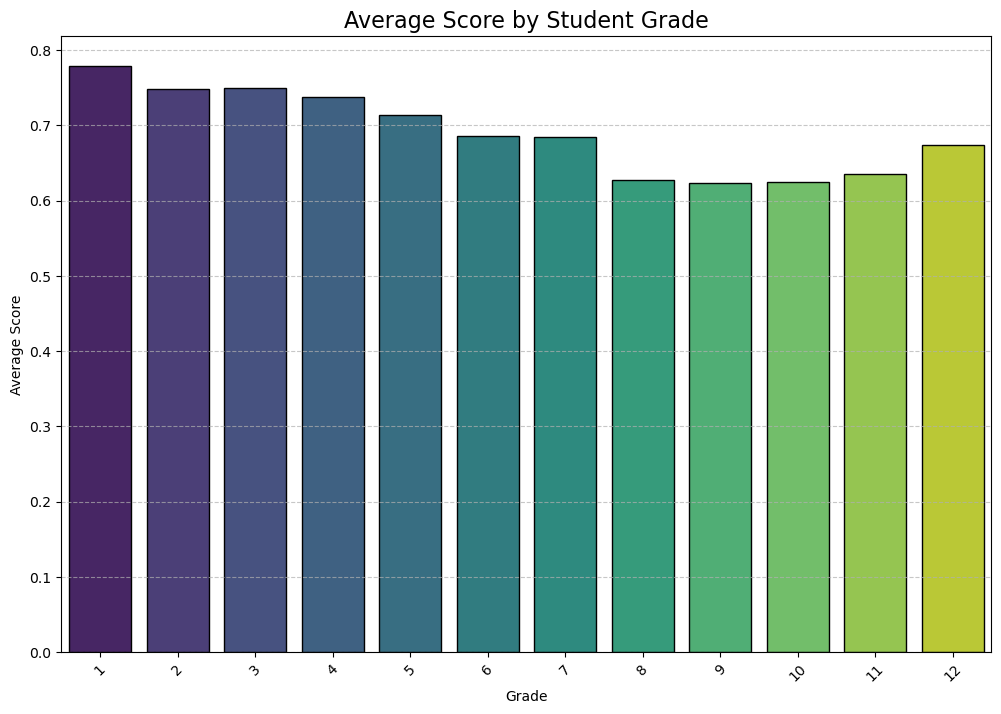

In [16]:
# Convert the PySpark DataFrame to a Pandas DataFrame
performance_by_grade_pd = performance_by_grade.toPandas()

# Plot the average score by student grade
plt.figure(figsize=(12, 8))
sns.barplot(x='user_grade', y='average_score', data=performance_by_grade_pd, palette='viridis', edgecolor='black')
plt.title('Average Score by Student Grade', fontsize = 16)
plt.xlabel('Grade')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Performace by Gender

In [17]:
# Analyze performance by gender
performance_by_gender = student_performance.groupBy('gender').agg(
    avg('score').alias('average_score')
)

performance_by_gender.show()

+-----------+------------------+
|     gender|     average_score|
+-----------+------------------+
|       null|0.6863409096148999|
|     female|0.7139499181073535|
|unspecified|0.7021105730098192|
|       male|0.7137804515611136|
+-----------+------------------+



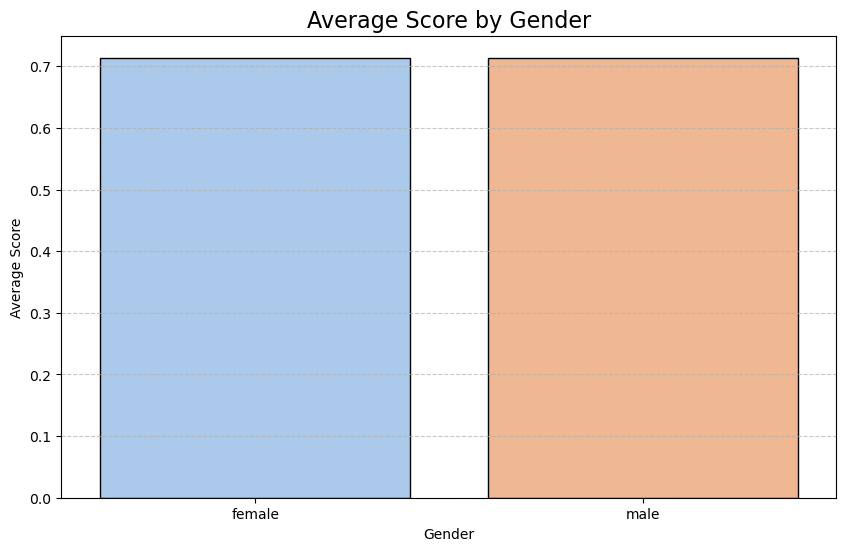

In [18]:
# Filter the DataFrame to only include male and female
filtered_gender_df = performance_by_gender.filter(performance_by_gender['gender'].isin(['male', 'female']))

# Convert the PySpark DataFrame to a Pandas DataFrame
performance_by_gender_pd = filtered_gender_df.toPandas()

# Plot the average score by gender
plt.figure(figsize=(10, 6))
sns.barplot(x='gender', y='average_score', data=performance_by_gender_pd, palette='pastel', edgecolor='black')
plt.title('Average Score by Gender', fontsize=16)
plt.xlabel('Gender')
plt.ylabel('Average Score')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Performance by City

In [19]:
# Analyze performance by city
performance_by_city = student_performance.groupBy('user_city').agg(
    avg(col('score')).alias('average_score'),
    max(col('score')).alias('max_score'),
    min(col('score')).alias('min_score')
).orderBy('user_city')

performance_by_city.show()

+---------+------------------+---------+---------+
|user_city|     average_score|max_score|min_score|
+---------+------------------+---------+---------+
|      chc|0.7061098493260015|        1|        0|
|       cy|0.7128087321542494|        1|        0|
|       hc|0.6641481686718742|        1|        0|
|      hlc|0.6377476003603343|        1|        0|
|      ilc|0.7083311324601678|        1|        0|
|       kh|0.7314613292440854|        1|        0|
|       kl|0.7298523420117318|        1|        0|
|       km|0.7510960351288178|        1|        0|
|       lj|0.6828169532040085|        1|        0|
|       ml|0.6495925123592481|        1|        0|
|     ntct|0.6618742900145986|        1|        0|
|     ntpc|0.7266838179903876|        1|        0|
|      phc|0.6803991124553048|        1|        0|
|      ptc|0.6534127281958456|        1|        0|
|       tc|0.7016864268285917|        1|        0|
|       tn|0.7061037618707382|        1|        0|
|       tp|0.7342042586638762| 

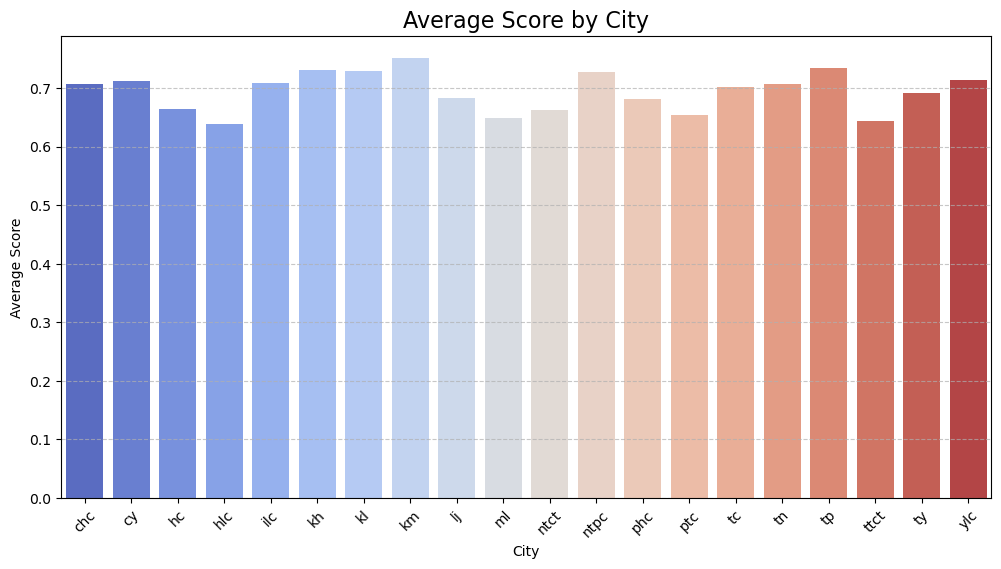

In [20]:
# Plot the average score by city
performance_by_city_pd = performance_by_city.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x='user_city', y='average_score', data=performance_by_city_pd, palette='coolwarm')
plt.title('Average Score by City', fontsize=16)
plt.xlabel('City')
plt.ylabel('Average Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

Engagement and Scores Analysis

In [21]:
# Ensure the correct data types for aggregation columns
student_performance = student_performance.withColumn('total_sec_taken', col('total_sec_taken').cast('double'))
student_performance = student_performance.withColumn('used_hint_cnt', col('used_hint_cnt').cast('int'))
student_performance = student_performance.withColumn('total_attempt_cnt', col('total_attempt_cnt').cast('int'))

In [22]:
# Analyze engagement and scores
engagement_scores = student_performance.groupBy('uuid').agg(
    avg('total_sec_taken').alias('avg_time_spent'),
    avg('score').alias('average_score'),
    sum('used_hint_cnt').alias('total_hints_used'),
    sum('total_attempt_cnt').alias('total_attempts')
)

engagement_scores.show(10)

+--------------------+------------------+-------------------+----------------+--------------+
|                uuid|    avg_time_spent|      average_score|total_hints_used|total_attempts|
+--------------------+------------------+-------------------+----------------+--------------+
|vWdGxGQwcZXltWscM...|20.834586466165412|  0.518796992481203|              58|           216|
|baP3hAJAHXLyeJUdT...| 31.44638403990025| 0.9052369077306733|              15|           465|
|18q02emB0a+6JtKf/...| 50.50156862745098| 0.7370588235294118|            2826|          8348|
|yh/W1JQSK4yORzLPR...| 53.96586501163693| 0.7377812257564003|             878|          4665|
|DKn2f611ZxvLpmJ1D...| 87.36940298507463| 0.6492537313432836|             230|           388|
|6THyTu2YsMnAjHQ77...|17.522807017543858| 0.7929824561403509|              44|           385|
|nA+wmRjJTe0yI53n+...| 33.94904458598726|0.37261146496815284|             311|           655|
|hbSQBt8vw0oSsCG9B...| 51.29095354523228| 0.7726161369193154

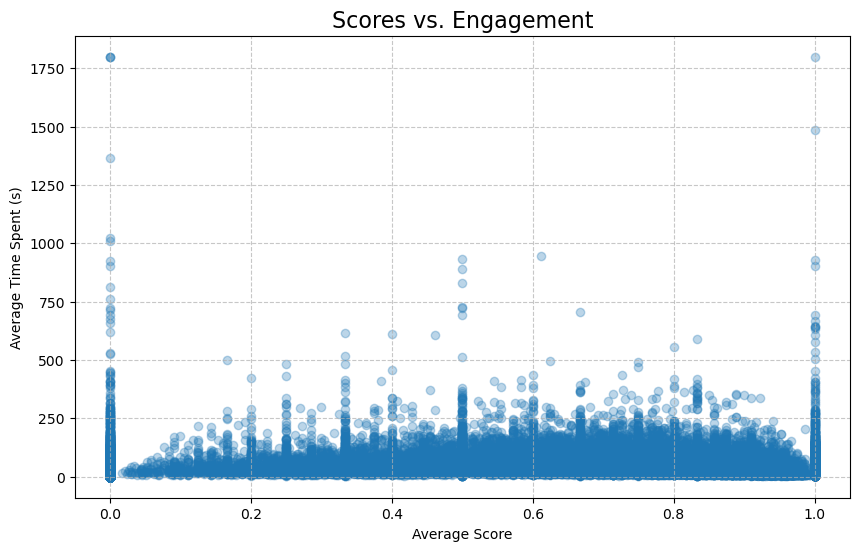

In [23]:
# Convert engagement_scores to Pandas DataFrame for visualization
engagement_data = engagement_scores.toPandas()

# Visualize the relationship between average time spent and average score
plt.figure(figsize=(10, 6))
plt.scatter(engagement_data['average_score'], engagement_data['avg_time_spent'], alpha=0.3)
plt.title('Scores vs. Engagement', fontsize=16)
plt.xlabel('Average Score')
plt.ylabel('Average Time Spent (s)')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

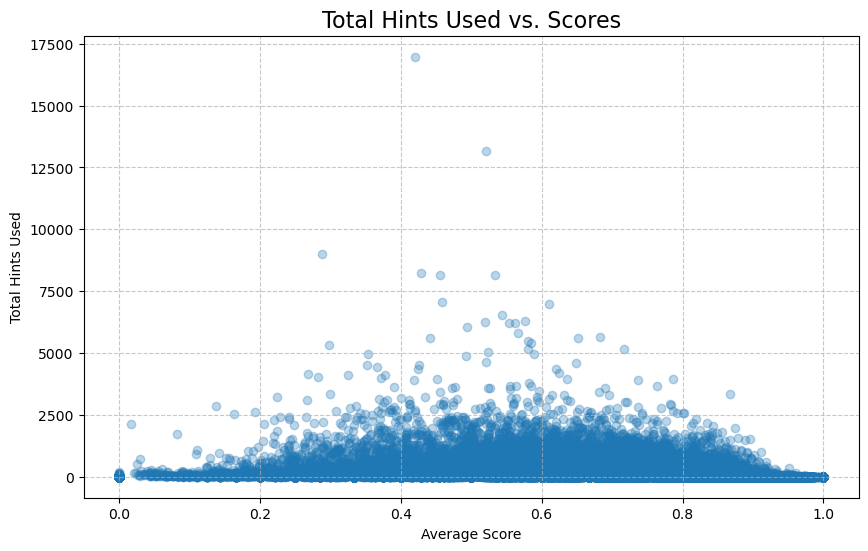

In [24]:
# Visualize the relationship between total hints used and average score
plt.figure(figsize=(10, 6))
plt.scatter(engagement_data['average_score'], engagement_data['total_hints_used'], alpha=0.3)
plt.title('Total Hints Used vs. Scores', fontsize=16)
plt.xlabel('Average Score')
plt.ylabel('Total Hints Used')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()


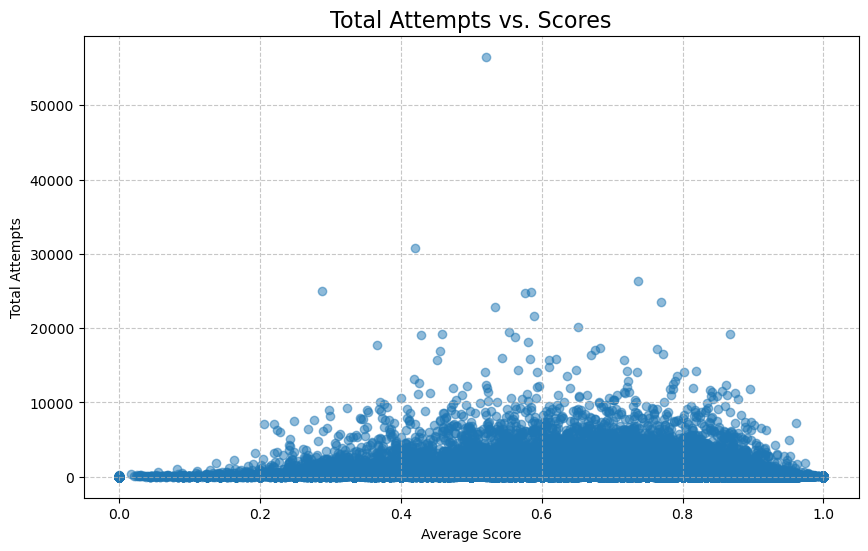

In [25]:
# Visualize the relationship between total attempts and average score
plt.figure(figsize=(10, 6))
plt.scatter(engagement_data['average_score'], engagement_data['total_attempts'], alpha=0.5)
plt.title('Total Attempts vs. Scores', fontsize=16)
plt.xlabel('Average Score')
plt.ylabel('Total Attempts')
plt.grid(True, linestyle='--', alpha=0.7)

plt.show()

Comparative Analysis Across Groups

In [26]:
# Merge dataframes to include user information
student_performance = log_problem_df.join(info_user_data_df, 'uuid')

In [27]:
# Ensure the correct data types for aggregation columns
student_performance = student_performance.withColumn('score', (col('is_correct').cast('int')))
student_performance = student_performance.withColumn('total_sec_taken', col('total_sec_taken').cast('double'))
student_performance = student_performance.withColumn('avg_hints_per_attempt', col('used_hint_cnt') / col('total_attempt_cnt'))

In [28]:
# Analyze the performance and engagement of self-taught and non-self-taught students
performance_by_coach = student_performance.groupBy('is_self_coach').agg(
    avg('score').alias('average_score'),
    avg('total_sec_taken').alias('avg_time_spent'),
    avg('avg_hints_per_attempt').alias('avg_hints_per_attempt')
)

performance_by_coach.show()

+-------------+------------------+------------------+---------------------+
|is_self_coach|     average_score|    avg_time_spent|avg_hints_per_attempt|
+-------------+------------------+------------------+---------------------+
|         true|0.7674186174001574|41.329226133426815|   0.1616781460785762|
|        false|0.7026560765191203| 44.43298031169533|  0.22117773468178054|
+-------------+------------------+------------------+---------------------+



In [29]:
# Convert the PySpark DataFrame to a Pandas DataFrame
performance_by_coach_pd = performance_by_coach.toPandas()

# Set labels for the plots
labels = ['Self-Coach', 'Non-Self-Coach']

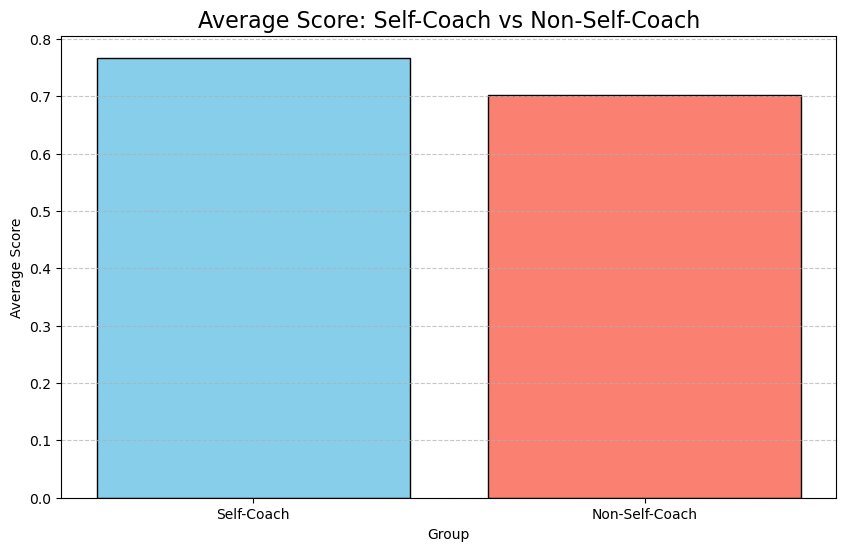

In [30]:
# Plot a bar chart of average scores
plt.figure(figsize=(10, 6))
plt.bar(labels, performance_by_coach_pd['average_score'], color=['skyblue', 'salmon'], edgecolor='black')
plt.xlabel('Group')
plt.ylabel('Average Score')
plt.title('Average Score: Self-Coach vs Non-Self-Coach', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

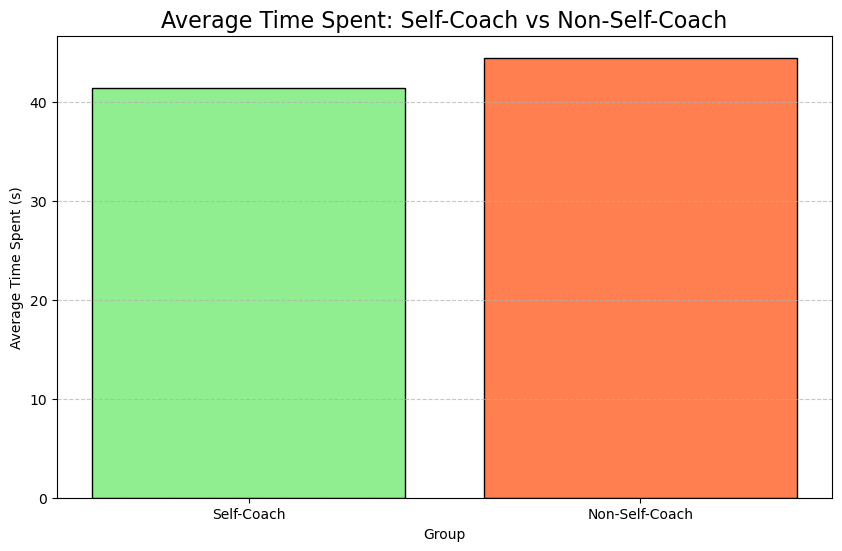

In [31]:
# Plot a bar chart of average time spent
plt.figure(figsize=(10, 6))
plt.bar(labels, performance_by_coach_pd['avg_time_spent'], color=['lightgreen', 'coral'], edgecolor='black')
plt.xlabel('Group')
plt.ylabel('Average Time Spent (s)')
plt.title('Average Time Spent: Self-Coach vs Non-Self-Coach', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

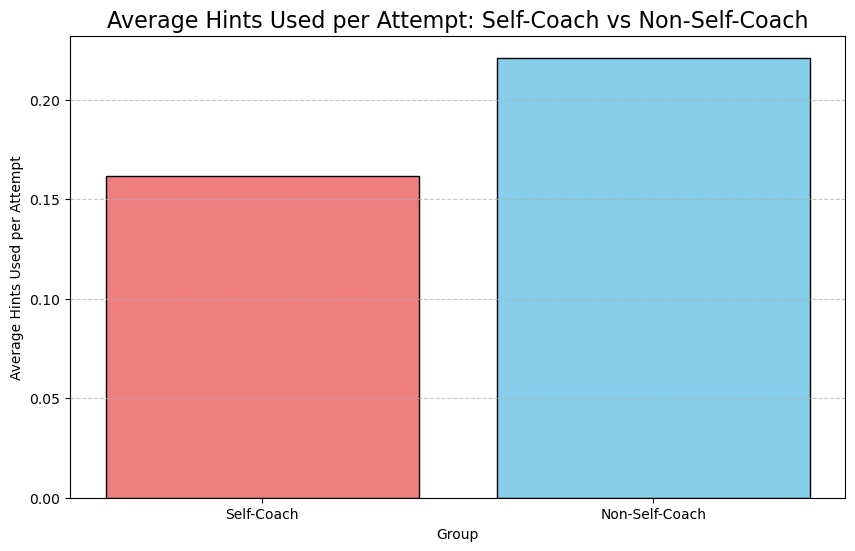

In [32]:
# Plot a bar chart of the total number of hints used
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, performance_by_coach_pd['avg_hints_per_attempt'], color=['lightcoral', 'skyblue'], edgecolor='black')
plt.xlabel('Group')
plt.ylabel('Average Hints Used per Attempt')
plt.title('Average Hints Used per Attempt: Self-Coach vs Non-Self-Coach', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Model building and validation

In [33]:
import pandas as pd
import numpy as np
from pyspark.sql.functions import when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [34]:
# Convert data to feature vectors
assembler = VectorAssembler(inputCols=["total_sec_taken", "total_attempt_cnt", "used_hint_cnt"], outputCol="features")
student_data = assembler.transform(student_performance).select('features', 'score')

In [35]:
# Convert score to a binary classification problem (1 for pass, 0 for fail)
student_data = student_data.withColumn('label', when(col('score') >= 0.6, 1).otherwise(0))

Select and train machine learning models

In [36]:
# Divide the training set and test set
train_data, test_data = student_data.randomSplit([0.7, 0.3], seed=42)

In [37]:
# Initialize the logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='label')

# Train the model
lr_model = lr.fit(train_data)
print("Logistic Regression model trained.")

Logistic Regression model trained.


In [38]:
# Initialize the random forest model
rf = RandomForestClassifier(featuresCol='features', labelCol='label', numTrees=10)

# Train the model
rf_model = rf.fit(train_data)
print("Random Forest model trained.")

Random Forest model trained.


Model evaluation

In [39]:
# Initializes the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# Evaluate the logistic regression model
lr_predictions = lr_model.transform(test_data)
lr_accuracy = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression Model Accuracy: {lr_accuracy}")

Logistic Regression Model Accuracy: 0.9965469417326228


In [40]:
# Evaluate the random forest model
rf_predictions = rf_model.transform(test_data)
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Random Forest Model Accuracy: {rf_accuracy}")

Random Forest Model Accuracy: 0.9965469417326228


Hyperparameter tuning

In [49]:
# Create parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

In [50]:
# Initialize cross validation
crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=3)

In [51]:
# Train the model using cross-validation
cv_model = crossval.fit(train_data)
print("Cross-validation completed.")

Cross-validation completed.


In [52]:
# Evaluate the best model
cv_predictions = cv_model.transform(test_data)
cv_accuracy = evaluator.evaluate(cv_predictions)
print(f"Best Model Accuracy after Cross-validation: {cv_accuracy}")

Best Model Accuracy after Cross-validation: 0.9429061198241646


In [53]:
# Get the coefficients of the best model
best_model = cv_model.bestModel
coefficients = best_model.coefficients
intercept = best_model.intercept

print("Coefficients: ", coefficients)
print("Intercept: ", intercept)

Coefficients:  [0.0,-2.197038047946427,-2.707394897683533]
Intercept:  4.9183694305649865


Results interpretation and reporting

In [54]:
# Map coefficients to feature names
features = assembler.getInputCols()
coef_list = coefficients.toArray().tolist()
feature_importance = dict(zip(features, coef_list))

print("Feature Importance: ", feature_importance)

Feature Importance:  {'total_sec_taken': 0.0, 'total_attempt_cnt': -2.197038047946427, 'used_hint_cnt': -2.707394897683533}


In [55]:
# Create a final report
report = {
    "Logistic Regression Accuracy": lr_accuracy,
    "Random Forest Accuracy": rf_accuracy,
    "Best Model Accuracy after Cross-validation": cv_accuracy,
    "Feature Importances": feature_importance
}

print("Final Report: ", report)

Final Report:  {'Logistic Regression Accuracy': 0.9965469417326228, 'Random Forest Accuracy': 0.9965469417326228, 'Best Model Accuracy after Cross-validation': 0.9429061198241646, 'Feature Importances': {'total_sec_taken': 0.0, 'total_attempt_cnt': -2.197038047946427, 'used_hint_cnt': -2.707394897683533}}
